# Import statements

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from fast_ml.model_development import train_valid_test_split
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import pathlib

2.17.0


# Preprocessing 

In [12]:
# Create a function to calculate the mean over the entire dataset
def compute_dataset_mean(selected_classes, normalize=True):
    dog_class_directory = os.getcwd()+'/dog_classes'
    
    total_sum = np.zeros(3)  # Assuming RGB images
    total_count = 0

    for class_name in selected_classes:
        class_dir = os.path.join(dog_class_directory, class_name)
        if not os.path.isdir(class_dir):
            print(f"Directory for class '{class_name}' not found, skipping.")
            continue
        
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.endswith(('.jpg', '.jpeg', '.png')):  # Adjust as needed for your image types
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)
                
                if normalize:
                    img_array /= 255.0  # Normalize to [0, 1]
                    
                total_sum += np.mean(img_array, axis=(0, 1))  # Mean over width, height for each channel
                total_count += 1

    if total_count == 0:
        print("No images found for the selected classes.")
        return None
    
    dataset_mean = total_sum / total_count
    return dataset_mean

In [13]:
# Zero-centering function
def zero_centering(image, dataset_mean):
    return image - dataset_mean

# Modify the dataset to apply zero-centering and normalization
def apply_zero_centering(dataset, dataset_mean, normalize=True):
    # Apply feature-wise centering and optional normalization
    def process_image(img, label):
        if normalize:
            img = img / 255.0  # Normalize to [0, 1] if normalize is True
        img = zero_centering(img, dataset_mean)  # Zero-center the image
        return img, label

    # Apply feature-wise centering and normalization by mapping the function
    zero_centered_dataset = dataset.map(
        process_image,
        num_parallel_calls=tf.data.AUTOTUNE  # Use parallel calls for efficiency
    )

    return zero_centered_dataset

# Model training

In [14]:
def get_classes(n: int):
    dog_class_directory = os.getcwd()+'/dog_classes'
    return os.listdir(dog_class_directory)[:n]

# See the classes to train on
#selected_classes = get_classes(10)

# 5 white coloured breeds, but dissimilar appearence 
#selected_classes = ['214-n000033-Bedlington_terrier', '211-n000058-Sealyham_terrier', '209-n000040-West_Highland_white_terrier', '225-n000073-Great_Pyrenees']

#breeds that look like a labrador
selected_classes = ['207-n000045-redbone', '206-n000047-flat_coated_retriever', '215-n000075-Chesapeake_Bay_retriever', '202-n000028-curly_coated_retriever', '210-n000048-vizsla', '211-n000059-German_short_haired_pointer', '230-n000080-Rhodesian_ridgeback', '235-n000096-Weimaraner']
print(len(selected_classes))
print(selected_classes)

8
['207-n000045-redbone', '206-n000047-flat_coated_retriever', '215-n000075-Chesapeake_Bay_retriever', '202-n000028-curly_coated_retriever', '210-n000048-vizsla', '211-n000059-German_short_haired_pointer', '230-n000080-Rhodesian_ridgeback', '235-n000096-Weimaraner']


In [15]:
import os

def get_classes(n: int):
    dog_class_directory = os.getcwd() + '/dog_classes'
    return os.listdir(dog_class_directory)[:n]


# Print the number of elements (images) in each class
dog_class_directory = os.getcwd() + '/dog_classes'  # Define the directory path again

for c in selected_classes:
    class_directory = os.path.join(dog_class_directory, c)  # Full path to the class folder
    # List files in the class folder and count them
    num_images = len([f for f in os.listdir(class_directory) if os.path.isfile(os.path.join(class_directory, f))])
    print(f"Class '{c}' has {num_images} images.")


Class '207-n000045-redbone' has 207 images.
Class '206-n000047-flat_coated_retriever' has 206 images.
Class '215-n000075-Chesapeake_Bay_retriever' has 215 images.
Class '202-n000028-curly_coated_retriever' has 202 images.
Class '210-n000048-vizsla' has 210 images.
Class '211-n000059-German_short_haired_pointer' has 211 images.
Class '230-n000080-Rhodesian_ridgeback' has 230 images.
Class '235-n000096-Weimaraner' has 235 images.


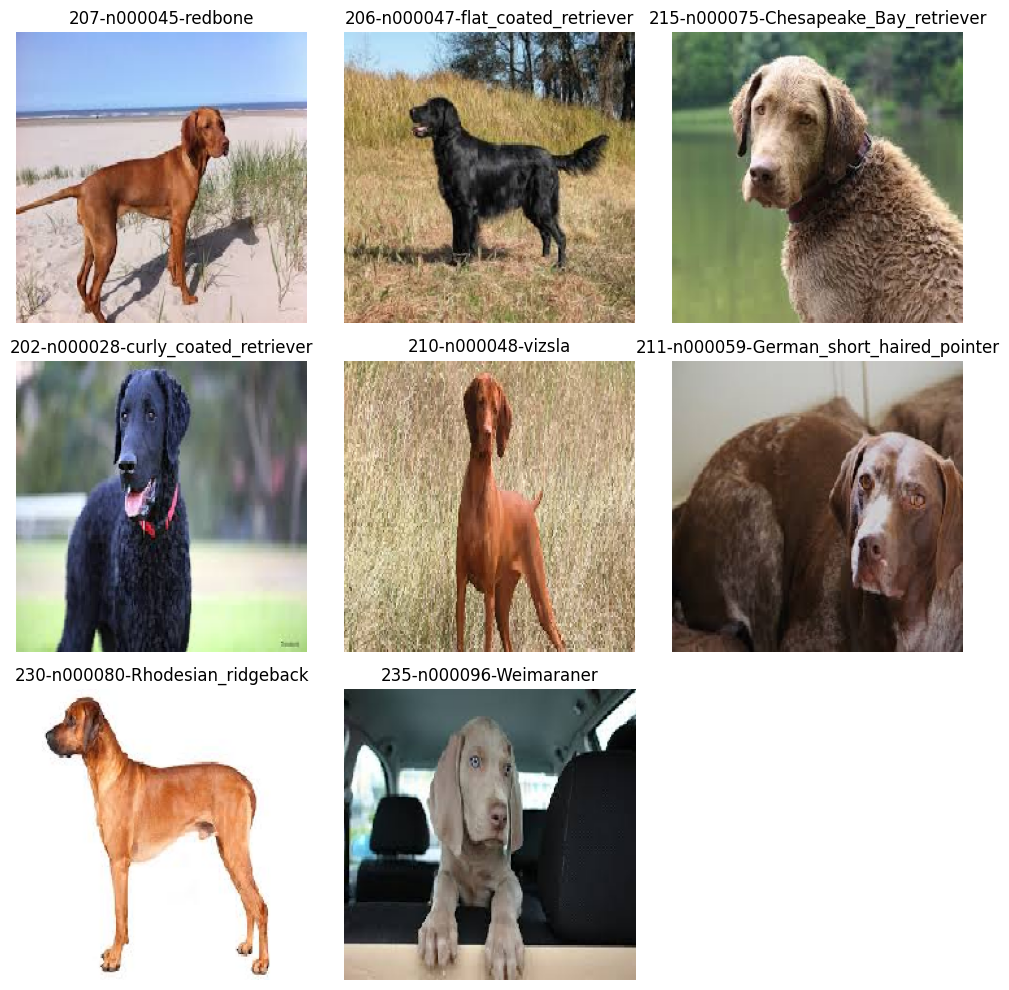

In [16]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

dog_class_directory = os.getcwd() + '/dog_classes'

# Set up the figure for displaying images
plt.figure(figsize=(10, 10))

# Loop over each class and display the first image
for i, class_name in enumerate(selected_classes):
    class_directory = os.path.join(dog_class_directory, class_name)
    image_files = os.listdir(class_directory)
    
    # Check if there are images in the class directory
    if image_files:
        first_image_path = os.path.join(class_directory, image_files[0])
        
        # Load and display the first image
        img = load_img(first_image_path, target_size=(224, 224))  # Resize for consistent display size
        ax = plt.subplot(3, 3, i + 1)  # Adjust grid as per number of classes
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.show()


In [19]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
#conv_base.summary()

In [28]:
# Add new top layer
x = conv_base.output #the output of base model to go into top layers
x = GlobalAveragePooling2D()(x) #notsure
x = Dense(1024,activation='relu')(x) #dense layer, dafuq
#x = Dropout(0.5)(x)  # Dropout added here
preds = Dense(len(selected_classes),activation='softmax')(x) #final layer with softmax activation to make class predictions

# Specify model, combination of encoder and customised top layer
model = Model(inputs=conv_base.input, outputs=preds)

In [29]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


In [30]:
dog_class_directory = os.getcwd()+'/dog_classes'
dataset_mean = compute_dataset_mean(selected_classes, normalize=False)

In [31]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=32,
    subset = "training",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=32,
    subset = "validation",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

Found 1716 files belonging to 8 classes.
Using 1373 files for training.
Found 1716 files belonging to 8 classes.
Using 343 files for validation.


In [32]:
zero_norm_train_dataset = apply_zero_centering(train_dataset, dataset_mean, normalize=False)
zero_norm_val_dataset = apply_zero_centering(val_dataset, dataset_mean, normalize=False)

In [ ]:
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history = model.fit(zero_norm_train_dataset, 
          validation_data=zero_norm_val_dataset, 
          epochs=50)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.1955 - loss: 2.0918

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


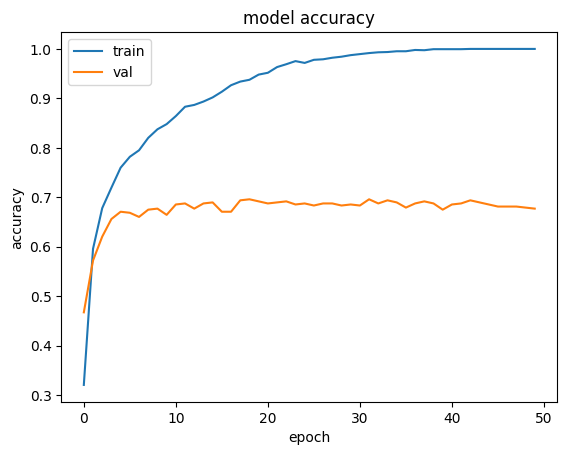

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### We are now ready to start training the model using


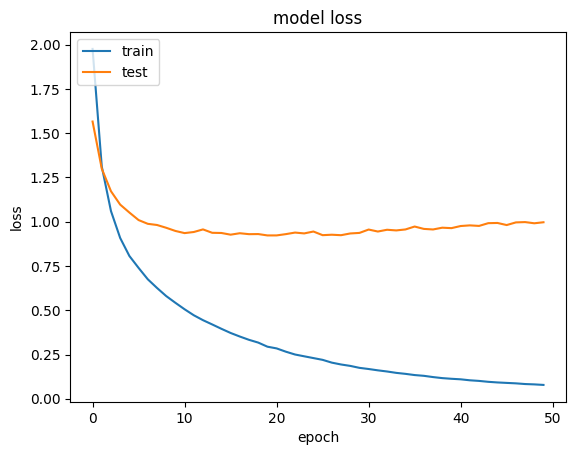

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()